# **Multi-Modal Retrieval using VoyageAI Multi-Modal Embeddings**

VoyageAI has released a multi-modal embedding model and in this notebook, we will demonstrate Multi-Modal Retrieval using VoyageAI MultiModal Embeddings.

For the demonstration, here are the steps:

1. Download a dataset with images from HuggingFace.
2. Build a Multi-Modal index for images using VoyageAI Multi-Modal Embeddings.
3. Retrieve relevant images simultaneously using a Multi-Modal Retriever for a query.

# **Installation**

We will use VoyageAI MultiModal embeddings for retrieval and MongoDB as the vector-store.

In [ ]:
%pip install datasets
%pip install llama-index
%pip install llama-index-embeddings-voyageai
%pip install llama-index-vector-stores-mongodb
%pip install pymongo
%pip install matplotlib

In [ ]:
import base64
import os
from io import BytesIO
from time import sleep

from PIL import Image
from datasets import load_dataset
from llama_index.core import StorageContext
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.core.schema import ImageDocument
from llama_index.core.settings import Settings
from llama_index.embeddings.voyageai import VoyageEmbedding
from llama_index.vector_stores.mongodb import MongoDBAtlasVectorSearch
from pymongo import MongoClient
import matplotlib.pyplot as plt

# **Utils**

* plot_images: Plot the images in the specified list of image paths.



In [ ]:
def plot_images(images, image_indexes):
    images_shown = 0
    for image_ndx in image_indexes:
        image = Image.open(BytesIO(images[image_ndx]))

        plt.subplot(8, 8, images_shown + 1)
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])

        images_shown += 1
        if images_shown >= 50:
            break

    plt.tight_layout()
    plt.show()

# **Donwload the images**
We will download the dataset with the images.


In [ ]:
# Load the dataset
print("Loading dataset...")
dataset = load_dataset("princeton-nlp/CharXiv", split="validation")
df = dataset.to_pandas()

Loading dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.94k [00:00<?, ?B/s]

val.parquet:   0%|          | 0.00/66.8M [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/91.7M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1323 [00:00<?, ? examples/s]

Work with 50 images only.

In [ ]:
# Process images and store in MongoDB Atlas
print("Processing images...")
image_bytes = []
for index, row in df.iterrows():
    image_data = row["image"]
    if image_data is not None:
        image_bytes.append(image_data["bytes"])
        if len(image_bytes) == 50:
            break

Processing images...


Just show the images.

Showing images...


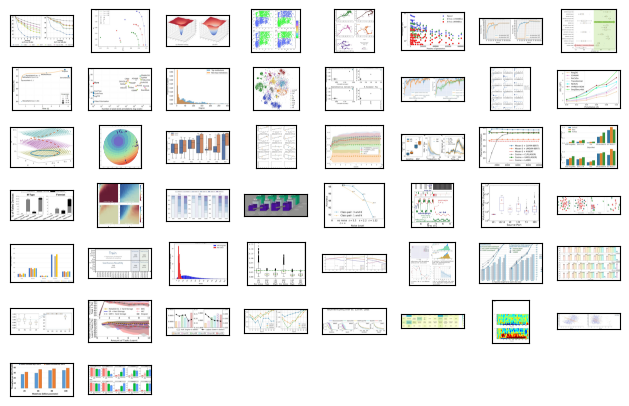

In [ ]:
print("Showing images...")
plot_images(image_bytes, [x for x in range(len(image_bytes))])

Now let's create documents, so we can then store these in the MongoDB database.

In [ ]:
print("Creting documents...")
documents = [
    ImageDocument(image=base64.b64encode(img), metadata={"index": ndx})
    for ndx, img in enumerate(image_bytes)
]

Creting documents...


Now, let's connect to MongoDB Atlas instance, define the image and text indexes and create the storage context. Also, initialise the multimodal embedding model.

In [ ]:
# Connect to MongoDB Atlas
print("Setup...")
# Use environment variables for sensitive credentials
MONGO_URI = os.environ.get("MONGO_URI", "<YOUR_MONGODB_ATLAS_URL>")
VOYAGE_API_KEY = os.environ.get("VOYAGE_API_KEY", "<YOUR_VOYAGE_API_KEY>")
db_name = "multimodal_test"
collection_name = "test"

client = MongoClient(MONGO_URI)

# Set up the image store for image embeddings
image_store = MongoDBAtlasVectorSearch(
    client,
    db_name=db_name,
    collection_name=f"{collection_name}_image",
    vector_index_name="image_vector_index",
)
image_store.create_vector_search_index(
    dimensions=1024, path="embedding", similarity="cosine"
)

# Set up the text store for text embeddings (if needed in the future)
text_store = MongoDBAtlasVectorSearch(
    client,
    db_name=db_name,
    collection_name=f"{collection_name}_text",
    vector_index_name="text_vector_index",
)
text_store.create_vector_search_index(
    dimensions=1024, path="embedding", similarity="cosine"
)

# Create storage context with proper assignment
storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

# Initialize Voyage AI embedding model
Settings.embed_model = VoyageEmbedding(
    voyage_api_key=VOYAGE_API_KEY,
    model_name="voyage-multimodal-3",
    truncation=False,
)
Settings.chunk_size = 100
Settings.chunk_overlap = 10

Setup...


We can now store the images in MongoDB.

In [ ]:
# Store documents in MongoDB Atlas Vector Search
print("Storing documents in MongoDB Atlas Vector Search...")
# Create a multimodal index that knows how to route different document types
index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
    show_progress=True,
    image_embed_model=Settings.embed_model,
)

print("Finished storing images.")

Storing documents in MongoDB Atlas Vector Search...


Parsing nodes:   0%|          | 0/50 [00:00<?, ?it/s]

Generating image embeddings:   0%|          | 0/50 [00:00<?, ?it/s]

Finished storing images.


In [ ]:
# Wait for indexing to complete (better to implement a proper check)

# **Test the Retrieval**
Here we create a retriever and test it out. Note that we are storing only images in our database, and we will query these images with plain text!

In [ ]:
# Create a retriever that specifically uses the image store
retriever = index.as_retriever(similarity_top_k=2)

# Perform a query
print("Performing query...")
nodes = retriever.text_to_image_retrieve(
    "3D loss landscapes for different training strategies"
)

Performing query...


Inspect the retrieval results

Found 2 results:


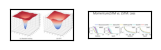

Querying finished


In [ ]:
# Display results
print(f"Found {len(nodes)} results:")
result_images = []
for i, node in enumerate(nodes):
    ndx = node.metadata["index"]
    result_images.append(ndx)
plot_images(image_bytes, result_images)

print("Querying finished")

We are done, so we can close the MongoDB connection.

In [ ]:
client.close()
print("MongoDB connection closed")

MongoDB connection closed
